In [1]:
import pandas as pd
import gbdt
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import random
from sklearn.cross_validation import cross_val_score
# plt.style.use('ggplot')

In [2]:
datasetframe = pd.read_csv('/Users/zhicongchen/Desktop/datasets/beijingmobile/datasetframe.csv')

In [3]:
datasetframe.head()

,ACC_NBR,URBAN_RURAL_ID,CUST_WORK_TYPE,CUST_LEVEL,IS_3G,PROB_LEVEL,CONSUME_AMT,WEB_FEE,ROAM_CALL_FEE,LOCAL_CALL_FEE,...,SMS_FEE,INNET_FLOAT_AMT,INNET_DUR,AGE,GENDER,__id,pagerank,triangle_count,Count,total_degree
0,10594,0,56.0,4,0,159.0,100.10,-0.30,0.8,37.75,...,2.1,84.01,484.08,57,0,10594,0.296388,138.0,6533397.0,345.0
1,10601,0,57.0,4,1,159.0,10.27,2.00,2.0,2.59,...,0.4,1.47,0.66,54,0,10601,0.265687,2.0,6533397.0,92.0
2,10685,0,56.0,4,0,159.0,42.72,-1.63,12.4,24.25,...,1.7,11.80,8.90,29,0,10685,0.150000,0.0,6533397.0,177.0
3,241044,0,56.0,3,0,46.0,17.68,0.00,0.0,12.75,...,3.2,15.18,0.46,44,1,241044,0.160056,3.0,6533397.0,253.0
4,241357,0,56.0,4,0,129.0,54.22,0.00,0.0,51.12,...,3.1,0.58,23.34,45,1,241357,0.234756,277.0,6533397.0,389.0


In [4]:
datasetframe.columns

Index([u'ACC_NBR', u'URBAN_RURAL_ID', u'CUST_WORK_TYPE', u'CUST_LEVEL',
       u'IS_3G', u'PROB_LEVEL', u'CONSUME_AMT', u'WEB_FEE', u'ROAM_CALL_FEE',
       u'LOCAL_CALL_FEE', u'LONG_CALL_FEE', u'CALL_FEE', u'VALUE_ADDED_FEE',
       u'SMS_FEE', u'INNET_FLOAT_AMT', u'INNET_DUR', u'AGE', u'GENDER',
       u'__id', u'pagerank', u'triangle_count', u'Count', u'total_degree'],
      dtype='object')

In [5]:
test_size = 0.3
random_state = 0
X_train, X_test = train_test_split(datasetframe, test_size=test_size, random_state=random_state)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

In [7]:
def ComputeAUC(forest, data, targets):
    predictions = forest.predict(data)
    fpr, tpr, _ = metrics.roc_curve(targets, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    # print "AUC = ", auc
    
    plt.figure()
    lw = 2 # line width
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

# GBDT

## prepare data

In [6]:
training_data = gbdt.DataLoader.from_df(X_train)

In [7]:
loss_func = 'logloss'
config = {'loss_func': loss_func,
          'num_trees': 20,
          'num_leaves': 16,
          'example_sampling_rate': 0.5,
          'feature_sampling_rate': 0.8,
          'pair_sampling_rate': 20,
          'min_hessian': 50,
          'shrinkage' : 0.05
#           ,'binarize_target' : True
         }

In [8]:
target_column = 'GENDER'
training_targets = map(lambda x: 1 if x==1 else -1, training_data[target_column])
# training_targets = list(training_data[target_column])
float_features = list(datasetframe.columns.drop(['__id', target_column
#                              ,
#                             'pagerank',
#                             'triangle_count',
#                             'total_degree'
                                                ]))

## train model

In [9]:
help(gbdt.train)

Help on function train in module gbdt._gbdt:

train(data_store, config, y=[], features=[], w=[], base_forest=None, random_seed=1234567, num_threads=16)
    Trains a gbdt model.
    Inputs: data_store: The Data Store.
            config: the config params. See https://github.com/yarny/gbdt/blob/master/src/proto/config.proto for all params.
            y: The target
            features: the list of features.
            w: The sampling weight.
            base_forest: The base forest upon which the training will continue.
            random_seed: the random seed.
            num_threads: The number of threads to run training with.
    Outputs: The forest.



In [10]:
forest = gbdt.train(training_data,
                    config=config,
                    y=training_targets,
                    features=float_features)

In [11]:
print >>open('forest.{}.json'.format(loss_func), 'w'), forest

## metrics

In [12]:
testing_data = gbdt.DataLoader.from_df(X_test)
testing_targets = map(lambda x: 1 if x==1 else -1, testing_data[target_column])
# training_targets = list(training_data[target_column])
# float_features = list(datasetframe.columns.drop(['__id', target_column]))


Feature Importance:
URBAN_RURAL_ID	1.0
AGE	0.890263600602
PROB_LEVEL	0.288225050476
CUST_WORK_TYPE	0.139979131663
LOCAL_CALL_FEE	0.13317876997
triangle_count	0.0984101434704
INNET_FLOAT_AMT	0.0959015747634
SMS_FEE	0.0930184060893
CUST_LEVEL	0.0755321877327
ROAM_CALL_FEE	0.069640884511
CALL_FEE	0.0542117842612
CONSUME_AMT	0.0378118576845
INNET_DUR	0.0235337817621
WEB_FEE	0.0200070018423
total_degree	0.0182828825384
LONG_CALL_FEE	0.0084063414283
pagerank	0.00361490452058
IS_3G	0.00306394839053
Testing: 


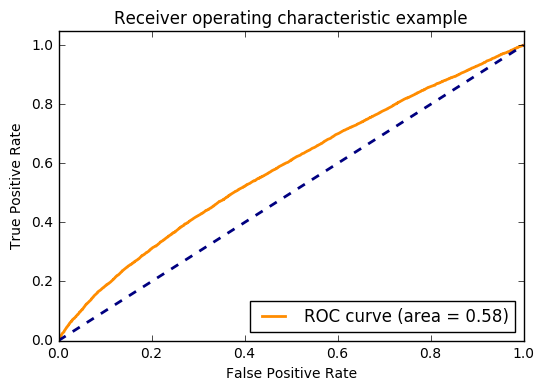

In [14]:
print "\nFeature Importance:"
print '\n'.join(['{0}\t{1}'.format(feature, imp) for feature,imp in forest.feature_importance()])

print "Testing: "
ComputeAUC(forest, testing_data, testing_targets)

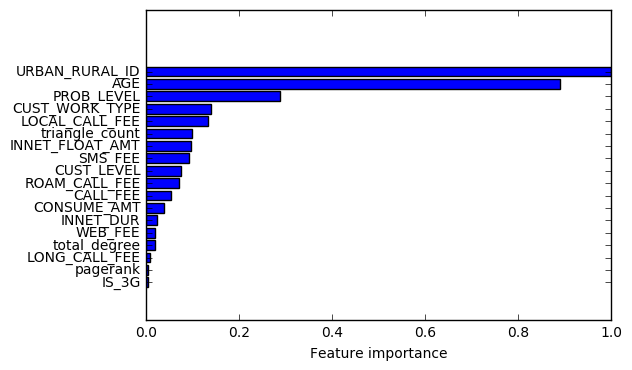

In [16]:
forest.feature_importance_bar_chart()

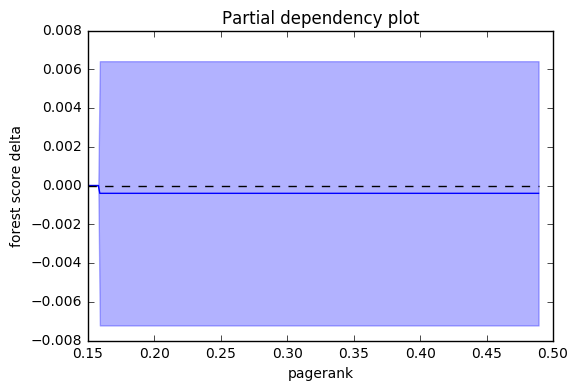

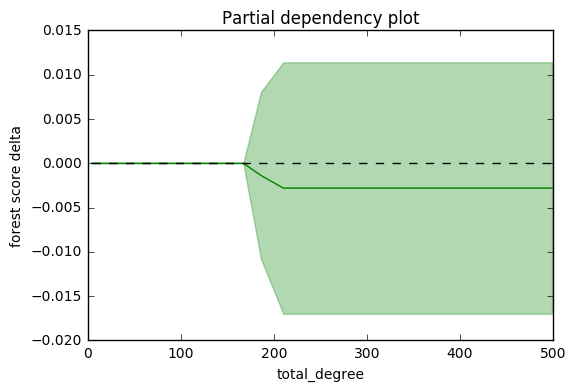

In [20]:
x = random.sample(training_data['pagerank'], 20)
x0 = random.sample(training_data['total_degree'], 20)
gbdt.plot_partial_dependency(forest, training_data, 'pagerank', x)
gbdt.plot_partial_dependency(forest, training_data, 'total_degree', x0, color='green')

In [80]:
help(gbdt.plot_partial_dependency)

Help on function plot_partial_dependency in module gbdt._partial_dependency_plot:

plot_partial_dependency(forest, data, feature, x, x0=None, log_scale=False, color='blue')
    Plots partial dependency graph.
    Plot forest(instance|f=x) - forest(instance|f=x0) vs x, where instance is
    a feature vector and instance|f=x represents the resulting feature vector after
    setting f to x.
    
    Inputs:
      forest: the forest model.
      data: the sample of data to plot the graph with.
      feature: the feature.
      x: the values to perturb the feature with.
      x0: the base feature value to compare with.



In [21]:
# Hard to draw
# visualizer = gbdt.ForestVisualizer(forest)
# visualizer.visualize_tree(10)

# Linear Regression

include network attrs:


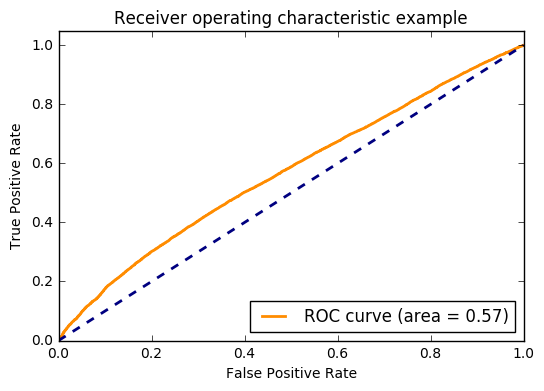

Mean Score = 0.0142497491304


In [8]:
features0 = ['URBAN_RURAL_ID',
            'AGE',
            'CONSUME_AMT',
            'PROB_LEVEL',
            'IS_3G',
            'CUST_WORK_TYPE',
            'CUST_LEVEL',
            'WEB_FEE',
            'VALUE_ADDED_FEE',
            'SMS_FEE',
            'INNET_FLOAT_AMT',
            'INNET_DUR',
            'GENDER',
            'CALL_FEE'
                ,
            'pagerank',
            'triangle_count',
            'total_degree'
            ]
    
features1 = ['URBAN_RURAL_ID',
            'AGE',
            'CONSUME_AMT',
            'PROB_LEVEL',
            'IS_3G',
            'CUST_WORK_TYPE',
            'CUST_LEVEL',
            'WEB_FEE',
            'VALUE_ADDED_FEE',
            'SMS_FEE',
            'INNET_FLOAT_AMT',
            'INNET_DUR',
            'GENDER',
            'CALL_FEE'
                ,
#             'pagerank',
#             'triangle_count',
#             'total_degree'
            ]



test_size = 0.3
random_state = 0
training_df, test_df = train_test_split(datasetframe, test_size=test_size, random_state=random_state)

target_column = 'GENDER'
features0.remove(target_column)
features1.remove(target_column)

training_targets = training_df[target_column]
training_data0 = training_df[features0]

lr0 = linear_model.LinearRegression()
lr0.fit(training_data0, training_targets)

testing_targets = test_df[target_column]
testing_data0 = test_df[features0]

print "include network attrs:"
# print "Training AUC =", ComputeAUC(lr0, training_data0, training_targets)
ComputeAUC(lr0, testing_data0, testing_targets)
print "Mean Score =", cross_val_score(lr0, training_data0, training_targets, cv=10).mean()

exclude network attrs:


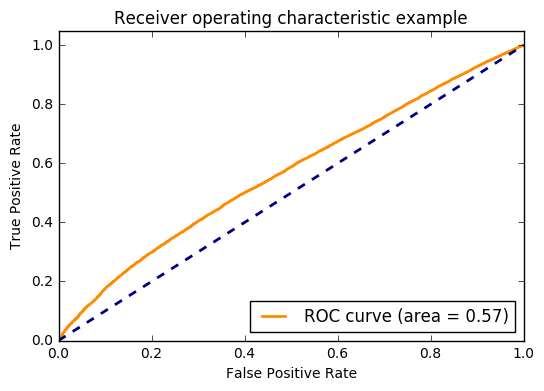

Mean Score = 0.013908474211


In [9]:
training_data1 = training_df[features1]
testing_data1 = test_df[features1]
lr1 = linear_model.LinearRegression()
lr1.fit(training_data1, training_targets)
print "exclude network attrs:"
# print "Training AUC =", ComputeAUC(lr1, training_data1, training_targets)
ComputeAUC(lr1, testing_data1, testing_targets)
print "Mean Score =", cross_val_score(lr1, training_data1, training_targets, cv=10).mean()

## roc curve contrast

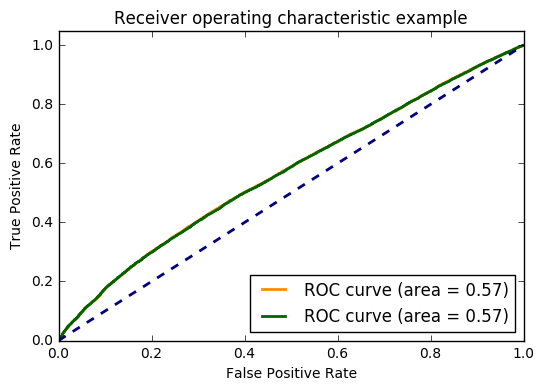

In [10]:
def model_contrast(model0, testing_data0, model1, testing_data1, testing_targets):
    predictions0 = model0.predict(testing_data0)
    fpr0, tpr0, _ = metrics.roc_curve(testing_targets, predictions0, pos_label=1)
    auc0 = metrics.auc(fpr0, tpr0)
    # print "AUC = ", auc
    predictions1 = model1.predict(testing_data1)
    fpr1, tpr1, _ = metrics.roc_curve(testing_targets, predictions1, pos_label=1)
    auc1 = metrics.auc(fpr1, tpr1)
    # print "AUC = ", auc
    
    plt.figure()
    lw = 2 # line width
    plt.plot(fpr0, tpr0, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc0)
    plt.plot(fpr1, tpr1, color='darkgreen',
             lw=lw, label='ROC curve (area = %0.2f)' % auc1)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
model_contrast(lr0, testing_data0, lr1, testing_data1, testing_targets)

In [14]:
help(metrics.classification._check_targets)

Help on function _check_targets in module sklearn.metrics.classification:

_check_targets(y_true, y_pred)
    Check that y_true and y_pred belong to the same classification task
    
    This converts multiclass or binary types to a common shape, and raises a
    ValueError for a mix of multilabel and multiclass targets, a mix of
    multilabel formats, for the presence of continuous-valued or multioutput
    targets, or for targets of different lengths.
    
    Column vectors are squeezed to 1d, while multilabel formats are returned
    as CSR sparse label indicators.
    
    Parameters
    ----------
    y_true : array-like
    
    y_pred : array-like
    
    Returns
    -------
    type_true : one of {'multilabel-indicator', 'multiclass', 'binary'}
        The type of the true target data, as output by
        ``utils.multiclass.type_of_target``
    
    y_true : array or indicator matrix
    
    y_pred : array or indicator matrix



In [16]:
def ComputeMetrics(model, data, targets):
    predictions = model.predict(data)
    fpr, tpr, _ = metrics.roc_curve(targets, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print "auc = ", auc
    
    predictions = model.predict(data)
    roc_auc_score = metrics.roc_auc_score(targets, predictions)
    print "roc_auc_score = ", roc_auc_score
    
    predictions = model.predict(data)
    r2_score = metrics.r2_score(targets, predictions)
    print "r2_score = ", r2_score
    
#     predictions = model.predict(data)
#     f1_score = metrics.f1_score(targets, predictions)
#     print "f1_score = ", f1_score
    
#     predictions = model.predict(data)
#     fbeta_score = metrics.fbeta_score(targets, predictions)
#     print "fbeta_score = ", fbeta_score

print "include network attrs:"
ComputeMetrics(lr0, training_data0, training_targets)
ComputeMetrics(lr0, testing_data0, testing_targets)
print 'exclude network attrs:'
ComputeMetrics(lr1, training_data1, training_targets)
ComputeMetrics(lr1, testing_data1, testing_targets)

include network attrs:
auc =  0.57135358528
roc_auc_score =  0.57135358528
r2_score =  0.0146219937013
auc =  0.56870603963
roc_auc_score =  0.56870603963
r2_score =  0.0136213067833
exclude network attrs:
auc =  0.570082330313
roc_auc_score =  0.570082330313
r2_score =  0.0142400675572
auc =  0.568006806281
roc_auc_score =  0.568006806281
r2_score =  0.0136350625064


# Xgboost